In [1]:
import uproot
import ROOT
import numpy as np
import pandas as pd
from collections import OrderedDict
from coffea import hist


from XRootD import client
from XRootD.client.flags import DirListFlags, StatInfoFlags, OpenFlags, MkDirFlags, QueryCode

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['grid.linestyle'] = ':'

Welcome to JupyROOT 6.12/04


In [2]:
import sys
print(sys.version)

3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]


In [3]:
import matplotlib as mpl
mpl.style.use('seaborn-bright')

In [4]:
web_dir = '/publicweb/m/mreid/iDM_AN_Plots/MetTriggerStudy'

# Define functions

In [5]:
def extract_teffi(eff):
    _ = ROOT.TCanvas()
    eff.Draw()
    ROOT.gPad.Update()
    
    tot = eff.GetTotalHistogram()
    nBins = tot.GetNbinsX()
    xx = []
    yy = []
    yl = []
    yu = []
    for i in range(1, nBins+1):
        if eff.GetEfficiency(eff.GetGlobalBin(i)) == 0 and eff.GetEfficiencyErrorUp(eff.GetGlobalBin(i)) == 1.: continue
        if eff.GetEfficiency(eff.GetGlobalBin(i)) == 1. and eff.GetEfficiencyErrorLow(eff.GetGlobalBin(i)) == 1.: continue
        
        xx.append(tot.GetXaxis().GetBinCenter(i))
        yy.append(eff.GetEfficiency(eff.GetGlobalBin(i)))
        yl.append(eff.GetEfficiencyErrorLow(eff.GetGlobalBin(i)))
        yu.append(eff.GetEfficiencyErrorUp(eff.GetGlobalBin(i)))
                  
    
    return {'x': np.array(xx),
            'y': np.array(yy),
            'yerr': np.array([yl, yu])}

In [45]:
import scipy.special
from scipy.optimize import curve_fit, fsolve
from scipy import odr

def fsigmoid(z, p0, p1):
    return 1.0 / (1.0 + np.exp(-p0*(z-p1)))
def ferf_cf(z, p0, p1, p2, p3):
    return p2 + p3*scipy.special.erf((z-p0)/p1)
def f98percentile_cf(z, p):
    return ferf_cf(z, *p) - (p[2]+p[3])*0.98
def ferf_odr(p, z):
    return p[2] + p[3]*scipy.special.erf((z-p[0])/p[1])
def f98percentile_odr(z, p):
    return ferf_odr(p, z) - (p[2]+p[3])*0.98

def make_plot(ax, sample, objs, variable, plot_props, event_selection='enrich'):
    h0 = ROOT.TH1F(f'h0_{sample}', '', len(plot_props['axis'])-1, plot_props['axis'])
    h1 = ROOT.TH1F(f'h1_{sample}', '', len(plot_props['axis'])-1, plot_props['axis'])
    for l,x in objs[event_selection][objs[event_selection]['fired0'] == True][variable].iteritems():
        h0.Fill(x)
    for l,x in objs[event_selection][(objs[event_selection]['fired'] == True) & (objs[event_selection]['fired0'] == True)][variable].iteritems():
        h1.Fill(x)
    #for l,x in objs[event_selection].query('fired0==True')[variable].iteritems():
    #    h0.Fill(x)
    #for l,x in objs[event_selection].query('fired0==True & fired==True')[variable].iteritems():
    #    h1.Fill(x)
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)
    xerr = np.insert(np.diff(data['x'])/2, 0, (data['x'][1]-data['x'][0])/2)
    ax.errorbar(x=data['x'], y=data['y'], xerr=xerr, yerr=data['yerr'], 
                label=f'{props["label"]}', markersize=3, alpha=0.3, fmt='o', c=objs['color'])
    
    selection_string = 'pre-selected events' if event_selection == 'df' else 'all events'
    ax.set_title(f'Trigger efficiency as a function of MET (over {selection_string})')
    ax.set_xlabel('MET pT [GeV]')
    ax.set_ylabel('Trigger efficiency')
    ax.set_ylim((0,1))
    
    return data

def make_plot_fit_cf(ax, sample, objs, variable, plot_props, event_selection='enrich'):
    data = make_plot(ax, sample, objs, variable, plot_props, event_selection)

    minbin = 0 if data['y'][0] < 0.1 else 1
    maxbin = -1
    print(data['yerr'][1][minbin:maxbin])
    popt, pcov = curve_fit(ferf_cf, data['x'][minbin:maxbin], data['y'][minbin:maxbin], sigma=data['yerr'][1][minbin:maxbin],
                           bounds=([50,0,-10,-10],[250,100,10,10]))
    print(fr"[{props['label']}]")
    print('fit parameter 1-sigma error')
    print('———————————–')
    for i in range(len(popt)):
        print(f'{popt[i]:.2f} +- {pcov[i,i]:.2f}')
    print('')
    
    percentile98 = fsolve(f98percentile_cf, 200, popt)
    fit_range = np.linspace(data['x'][minbin], data['x'][maxbin], 100)
    ax.plot(fit_range, ferf_cf(fit_range, *popt), c=objs['color'],
            label=f'Fit: pT @ 98% = {percentile98[0]:.0f} GeV')
    ax.legend()
    
def make_plot_fit_odr(ax, sample, objs, variable, plot_props, event_selection='enrich'):
    data = make_plot(ax, sample, objs, variable, plot_props, event_selection)

    minbin = 0 if data['y'][0] < 0.1 else 1
    maxbin = -1
    
    model = odr.Model(ferf_odr)
    xerror = np.repeat(data['x'][1]-data['x'][0], len(data['x'])-minbin)
    real_data = odr.RealData(data['x'][minbin:maxbin], data['y'][minbin:maxbin], sx=xerror, sy=data['yerr'][0][minbin:maxbin])
    odr_obj = odr.ODR(real_data, model, beta0=[132, 36, 0.5, 0.5])
    out = odr_obj.run()
    
    popt = out.beta
    perr = out.sd_beta
    print(fr"[{props['label']}]")
    print('fit parameter 1-sigma error')
    print('———————————–')
    for i in range(len(popt)):
        print(f'{popt[i]:.2f} +- {perr[i]:.2f}')
    print('')
    
    percentile98 = fsolve(f98percentile_odr, 200, popt)
    fit_range = np.linspace(data['x'][minbin], data['x'][maxbin], 100)
    ax.plot(fit_range, ferf_odr(popt, fit_range), c=objs['color'],
            label=f'Fit: pT @ 98% = {percentile98[0]:.0f} GeV')
    
    ax.legend()

# Load data

In [7]:
#redirector = 'root://cmseos.fnal.gov/'
#basedir = '/store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv3'
#samples = {
#    '5p25': {
#        'filename': redirector + basedir + '/Mchi-5p25_dMchi-0p5_ctau-100/MetTrigStudyv3_Mchi-5p25_dMchi-0p5_ctau-100.root',
#        'label': r'm1 = 5 GeV, $\Delta = 0.1$',
#        'color': 'C0'
#    },
#    '52p5': {
#        'filename': redirector + basedir + '/Mchi-52p5_dMchi-5p0_ctau-100/MetTrigStudyv3_Mchi-52p5_dMchi-5p0_ctau-100.root',
#        'label': r'm1 = 50 GeV, $\Delta = 0.1$',
#        'color': 'C1'
#    },
#    '6p0': {
#        'filename': redirector + basedir + '/Mchi-6p0_dMchi-2p0_ctau-100/MetTrigStudyv3_Mchi-6p0_dMchi-2p0_ctau-100.root',
#        'label': r'm1 = 5 GeV, $\Delta = 0.4$',
#        'color': 'C2'
#    },
#    '60p0': {
#        'filename': redirector + basedir + '/Mchi-60p0_dMchi-20p0_ctau-100/MetTrigStudyv3_Mchi-60p0_dMchi-20p0_ctau-100.root',
#        'label': r'm1 = 50 GeV, $\Delta = 0.4$',
#        'color': 'C3'
#    },
#}

In [8]:
xrdfs = client.FileSystem("root://cmseos.fnal.gov/")
redirector = 'root://cmseos.fnal.gov'
basedir = '/store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv3/backgrounds'

samples = {
    'WMuNu': {
        'label': 'WMuNu',
        'color': 'C0',
        'dir': ['WToMuNu_M-200_TuneCP5_13TeV-pythia8/crab_MetTrigEffi_WMuNu/190709_170657/0000'],
        'filename': []
    },
    'TT': {
        'label': 'TT',
        'color': 'C1',
        'dir': ['TTJets_TuneCP5_13TeV-madgraphMLM-pythia8/crab_MetTrigEffi_TTJets/190709_194623/0000',
                'TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/crab_MetTrigEffi_TTTo2L2Nu/190709_194810/0000',
                'TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/crab_MetTrigEffi_TTTo2L2Nu/190709_194810/0001',
                'TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/crab_MetTrigEffi_TTTo2L2Nu/190709_194810/0002',
                'TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/crab_MetTrigEffi_TTTo2L2Nu/190709_194810/0003',
                'TT_DiLept_TuneCP5_13TeV-amcatnlo-pythia8/crab_MetTrigEffi_TT_diLept/190709_194712/0000'
               ],
        'filename': []
    },
    'WJets': {
        'label': 'WJets',
        'color': 'C2',
        'dir': ['WJetsToLNu_HT-70To100_TuneCP5_13TeV-madgraphMLM-pythia8/crab_MetTrigEffi_WJetsToLNu_HT-70To100/190709_194343/0000',
                'WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/crab_MetTrigEffi_WJetsToLNu_HT-100To200/190709_194209/0000',
                'WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/crab_MetTrigEffi_WJetsToLNu_HT-100To200/190709_194209/0001',
                'WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/crab_MetTrigEffi_WJetsToLNu_HT-200To400/190709_194518/0000',
                'WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/crab_MetTrigEffi_WJetsToLNu_HT-200To400/190709_194518/0001',
                'WJetsToLNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8/crab_MetTrigEffi_WJetsToLNu_HT-400To600/190709_194256/0000'
               ],
        'filename': []
    },
    'DiBoson': {
        'label': 'DiBoson',
        'color': 'C3',
        'dir': ['ZZTo2L2Nu_TuneCP5_13TeV_powheg_pythia8/crab_MetTrigEffi_ZZTo2L2Nu/190709_193637/0000',
                'WZTo3LNu_TuneCP5_13TeV-powheg-pythia8/crab_MetTrigEffi_WZTo3LNu/190709_193550/0000',
                'WWTo2L2Nu_NNPDF31_TuneCP5_13TeV-powheg-pythia8/crab_MetTrigEffi_WWTo2L2Nu/190709_193728/0000',
                'WWJJToLNuLNu_QCD_noTop_13TeV-madgraph-pythia8/crab_MetTrigEffi_WWJJToLNuLNu/190709_193813/0000'
               ],
        'filename': []
    },
     'Data': {
        'label': 'Data',
        'color': 'C4',
        'dir': ['SingleMuon/crab_MetTrigEffi_singleMu_RunA_Jun/190709_221630/0000',
                'SingleMuon/crab_MetTrigEffi_singleMu_RunA_Jun/190709_221630/0001',
               ],
        'filename': []
    }
}
#status, listing = xrdfs.dirlist(f'{basedir}/backgrounds/WToMuNu_M-200_TuneCP5_13TeV-pythia8/crab_MetTrigEffi_WMuNu/190709_170657/0000', DirListFlags.STAT)
#print(listing)
#for file in listing:
#    if '.root' in file.name:
#        samples['WMuNu']['filename'].append(f'{redirector}/{basedir}/backgrounds/WToMuNu_M-200_TuneCP5_13TeV-pythia8/crab_MetTrigEffi_WMuNu/190709_170657/0000/{file.name}')

In [86]:
xrdfs = client.FileSystem("root://cmseos.fnal.gov/")
redirector = 'root://cmseos.fnal.gov'
basedir = '/store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv3/backgrounds'

samples = {
    'TTJets': {
        'label': 'TTJets',
        'color': 'C1',
        'dir': ['TTJets_TuneCP5_13TeV-madgraphMLM-pythia8/crab_MetTrigEffi_TTJets/190709_194623/0000'
               ],
        'filename': []
    },
        'TT': {
        'label': 'TT',
        'color': 'C1',
        'dir': [
                'TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/crab_MetTrigEffi_TTTo2L2Nu/190709_194810/0000'
               ],
        'filename': []
    },
        'TTDi': {
        'label': 'dilept',
        'color': 'C1',
        'dir': [
                'TT_DiLept_TuneCP5_13TeV-amcatnlo-pythia8/crab_MetTrigEffi_TT_diLept/190709_194712/0000'
               ],
        'filename': []
    }
    
}
#status, listing = xrdfs.dirlist(f'{basedir}/backgrounds/WToMuNu_M-200_TuneCP5_13TeV-pythia8/crab_MetTrigEffi_WMuNu/190709_170657/0000', DirListFlags.STAT)
#print(listing)
#for file in listing:
#    if '.root' in file.name:
#        samples['WMuNu']['filename'].append(f'{redirector}/{basedir}/backgrounds/WToMuNu_M-200_TuneCP5_13TeV-pythia8/crab_MetTrigEffi_WMuNu/190709_170657/0000/{file.name}')

In [75]:
xrdfs = client.FileSystem("root://cmseos.fnal.gov/")
redirector = 'root://cmseos.fnal.gov'
basedir = '/store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv3/backgrounds'

samples = {
    'ZZ': {
        'label': 'ZZ',
        'color': 'C0',
        'dir': ['ZZTo2L2Nu_TuneCP5_13TeV_powheg_pythia8/crab_MetTrigEffi_ZZTo2L2Nu/190709_193637/0000'
               ],
        'filename': []
    },
        'WZ': {
        'label': 'WZ',
        'color': 'C1',
        'dir': [
                'WZTo3LNu_TuneCP5_13TeV-powheg-pythia8/crab_MetTrigEffi_WZTo3LNu/190709_193550/0000'
               ],
        'filename': []
    },
        'WW': {
        'label': 'WW',
        'color': 'C2',
        'dir': [
                'WWTo2L2Nu_NNPDF31_TuneCP5_13TeV-powheg-pythia8/crab_MetTrigEffi_WWTo2L2Nu/190709_193728/0000'
               ],
        'filename': []
    },
        'WWJJ': {
        'label': 'WWJJ',
        'color': 'C3',
        'dir': [
                'WWJJToLNuLNu_QCD_noTop_13TeV-madgraph-pythia8/crab_MetTrigEffi_WWJJToLNuLNu/190709_193813/0000'
               ],
        'filename': []
    }
}
#status, listing = xrdfs.dirlist(f'{basedir}/backgrounds/WToMuNu_M-200_TuneCP5_13TeV-pythia8/crab_MetTrigEffi_WMuNu/190709_170657/0000', DirListFlags.STAT)
#print(listing)
#for file in listing:
#    if '.root' in file.name:
#        samples['WMuNu']['filename'].append(f'{redirector}/{basedir}/backgrounds/WToMuNu_M-200_TuneCP5_13TeV-pythia8/crab_MetTrigEffi_WMuNu/190709_170657/0000/{file.name}')

In [87]:
#MAX_FILES_LIST=50
for sample, objs in samples.items():
    for dirs in objs['dir']:
        print(dirs)
    #dirs = objs['dir']
        status, listing = xrdfs.dirlist(f'{basedir}/{dirs}', DirListFlags.STAT)
        #print(listing)
        for file in listing:
            if '.root' in file.name:
                samples[sample]['filename'].append(f'{redirector}/{basedir}/{dirs}/{file.name}')

TTJets_TuneCP5_13TeV-madgraphMLM-pythia8/crab_MetTrigEffi_TTJets/190709_194623/0000
TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/crab_MetTrigEffi_TTTo2L2Nu/190709_194810/0000
TT_DiLept_TuneCP5_13TeV-amcatnlo-pythia8/crab_MetTrigEffi_TT_diLept/190709_194712/0000


In [ ]:
%%time
MAX_FILES=400
#global_file_counter = 1
for sample, objs in samples.items():
    objs['df'] = []
    print(objs['label'])
    #if objs['label'] is not 'DiBoson':
    #    continue
    file_counter = 1
    for filex in objs['filename'][slice(0,MAX_FILES)]:
        if file_counter % 10 == 1:
            total = len(objs['filename'][slice(0,MAX_FILES)])
            print(f'Reading file {file_counter} of {total}')
                  #f' global {global_file_counter} of {num_files_total}'
                  #f' ({100*(global_file_counter-1)/num_files_total:.2f}%)')
        file_counter +=1
        #global_file_counter +=1
        
        file = uproot.open(filex)
        #print(filex)
    #file = uproot.open(objs['filename'])
    #objs['trig_tree'] = file['TRIG_dsa_HLT_PFMET120_PFMHT120/trigEffiForMuTrack']
    #objs['selftrig_tree'] = file['TRIGself_dsa_HLT_PFMET120_PFMHT120/trigSelfEffiForMuTrack']
    #objs['df'] = objs['trig_tree'].pandas.df()
    #objs['self_df'] = objs['selftrig_tree'].pandas.df()
        objs['trig_tree'] = file['RECO_dsa/MetTrigSelfEffiForMuTrack']
        objs['df'].append(objs['trig_tree'].pandas.df())
        #objs['df'] = objs['trig_tree'].pandas.df()
    objs['df'] = pd.concat(objs['df'])
    #print(len(objs['df'][(objs['df']['fired']==True) &(objs['df']['fired0']==True)]))
    #print(len(objs['df'][(objs['df']['fired0']==True)]))
    objs['enrich'] = objs['df'][(objs['df']['recoJetPt'] > 100) & (objs['df']['recoJetEta']<4.5) & (objs['df']['fired0']==1) & (objs['df']['pt']>25) & (objs['df']['eta']<2.5)]
    #print(objs['df'])
    objs['df'] = []

TTJets
Reading file 1 of 400
Reading file 11 of 400
Reading file 21 of 400
Reading file 31 of 400
Reading file 41 of 400
Reading file 51 of 400
Reading file 61 of 400
Reading file 71 of 400
Reading file 81 of 400
Reading file 91 of 400
Reading file 101 of 400
Reading file 111 of 400


In [23]:
#print(samples['WMuNu']['enrich'])

                fired  fired0           pt       eta       phi   recoJetPt  \
entry subentry                                                               
0     0         False    True    74.062225 -1.080376  2.815958  109.547295   
3     0         False    True    90.127884  0.333126  0.025677  111.291412   
8     0         False    True   115.144714  0.519089  0.309855  113.270912   
14    0         False    True   136.822021 -0.716454 -3.049919  188.192825   
15    0         False    True   155.661774 -0.261632  1.612180  166.013687   
16    0         False    True   280.458191 -0.244518  0.911637  118.174286   
18    0         False    True    97.282242 -0.188977  2.847278  120.799919   
23    0         False    True    29.022669  1.022321 -1.149789  131.796036   
26    0         False    True    96.178802  0.387682  2.982045  118.416687   
28    0         False    True   134.121628 -1.180356 -1.149314  133.935394   
29    0         False    True    57.406513 -2.124697  0.284058  

In [19]:
#_dict = {}
#for sample, props in samples.items():
#    _counts = props['df'].groupby('entry').nth(0)['fired'].value_counts()
#    print(_counts)
#    _dict[sample] = {}
#    _dict[sample]['num_total'] = props['self_df'].groupby('entry').nth(0)['fired'].value_counts().sum()
#    print(_dict[sample]['num_total'])
#    _dict[sample]['num_select'] = _counts.sum()
#    _dict[sample]['num_trig'] = _counts.iloc[0]
#    _dict[sample]['trig_over_total'] = _counts.iloc[0] / _dict[sample]['num_total']
#    _dict[sample]['trig_over_select'] = _counts.iloc[0] / _counts.sum()
#    
#pd.options.display.float_format = '{:,.2f}'.format
#df = pd.DataFrame(_dict)
#cols = ['num_total', 'num_select', 'num_trig', 'trig_over_total', 'trig_over_select']
#df = df.transpose()[cols].transpose()
#df.to_csv(web_dir + '/trigger_cutflow.csv')
#df

# Comparison of triggered vs pre-selected distributions with Coffea

# Comparison of triggered vs pre-selected distributions without Coffea

In [65]:
eff_plots = OrderedDict({
   # 'pt': {
   #     'axis': np.array(np.arange(25,50,3)), dtype='float64'),
   #     'range': [25, 100],
   #     'label': 'Leading muon pT [GeV]'
   # },
    'eta': {
        'axis': np.array(np.linspace(-2.4,2.4,6), dtype='float64'),
        'range': [-2.5, 2.5],
        'label': 'Leading muon eta'
    },
    'phi': {
        'axis': np.array(np.linspace(-3.1415,3.1415,6), dtype='float64'),
        'range': [-3.2, 3.2],
        'label': 'Leading muon phi'
    },
    'recoJetPt': {
        'axis': np.array(np.arange(50,500,50), dtype='float64'),
        'range': [100, 1000],
        'label': 'Leading jet pT [GeV]'
    },
    'recoJetEta': {
        'axis': np.array(np.linspace(-2.4,2.4,6), dtype='float64'),
        'range': [-2.5, 2.5],
        'label': 'Leading jet eta'
    },
    'recoJetPhi': {
        'axis': np.array(np.linspace(-3.1415,3.1415,6), dtype='float64'),
        'range': [-3.2, 3.2],
        'label': 'Leading jet phi'
    },
    'recoPFMetPt': {
        'axis': np.array(np.arange(0,400,5), dtype='float64'),
        'range': [0, 500],
        'label': 'MET pT [GeV]'
    },
    'recoPFMetPhi': {
         'axis': np.array(np.linspace(-3.1415,3.1415,6), dtype='float64'),
         'range':[-3.2,3.2],
         'label': 'MET phi'
     },
})
#     'recoPFMetPhi': {
#         'axis': np.array(np.linspace(-3.1415,3.1415,6), dtype='float64'),
#         'label': 'MET phi'
#     },

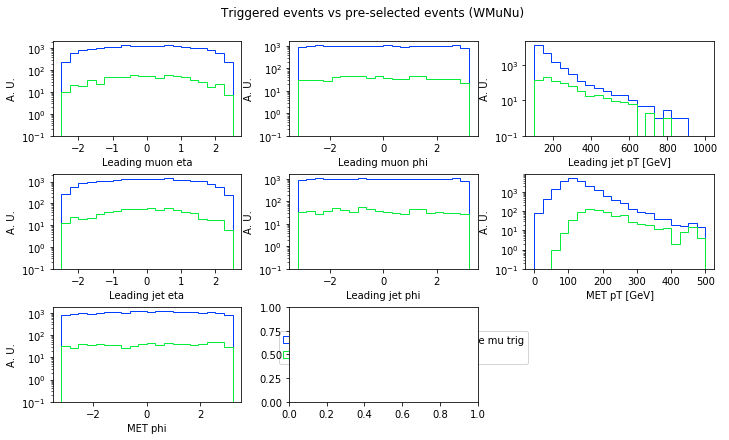

In [50]:
#sample = 'DiBoson'
sample = 'WMuNu'
#sample = 'TT'
#sample = 'WJets'

fig, axes = plt.subplots(3,3, figsize=(10,6))
fig.suptitle(f'Triggered events vs pre-selected events ({samples[sample]["label"]})')
plt.tight_layout(h_pad=2.0)
fig.subplots_adjust(top=0.90)
#axes[2,1].axis('off')
axes[2,2].axis('off')

for index, (column, props) in enumerate(eff_plots.items()):
    ax = axes[index//3, index%3]
    
    bin_edges = props['axis']
    kwargs = {'range': props['range'], 'bins':20, 'density': False, 'histtype':'step', 'log':True}
    
    df = samples[sample]['enrich'].groupby('entry').nth(0)
    #x.hist(df.query('fired0==True')[column].groupby('entry').nth(0), **kwargs, 
    #       label='Pre-selected events: passed single mu trig');
    #x.hist(df.query('fired0==True & fired==True')[column].groupby('entry').nth(0), **kwargs, 
    #       label='Pre-selected && triggered events');
    #print(df[['fired0','fired','recoPFMetPt']].groupby('entry').nth(0))
    #print(len(df[df['fired0']==True].groupby('entry').nth(0)))
    #print(len(df[['fired0','fired','recoPFMetPt']].groupby('entry').nth(0)))
    ax.hist(df[(df['fired0']==1)][column], **kwargs, 
            label='Pre-selected events: passed single mu trig');
    ax.hist(df[(df['fired0']==1) & (df['fired']==1)][column], **kwargs, 
            label='Pre-selected && triggered events');
    ax.set_xlabel(props['label'])
    ax.set_ylabel('A. U.')

ax.legend(loc=(1.2 ,0.4))
fig.savefig(f'{web_dir}/Trig_vs_preselected_{sample}.png', bbox_inches='tight')

# Trigger efficiency of `MET_120` vs kinematic variables -- pre-selected events

[-1.92 -0.96  0.    0.96  1.92]
[0.48 0.48 0.48 0.48 0.48]
[-1.92 -0.96  0.    0.96  1.92]
[0.48 0.48 0.48 0.48 0.48]
[-1.92 -0.96  0.    0.96  1.92]
[0.48 0.48 0.48 0.48 0.48]
[-1.92 -0.96  0.    0.96  1.92]
[0.48 0.48 0.48 0.48 0.48]
[-1.92 -0.96  0.    0.96  1.92]
[0.48 0.48 0.48 0.48 0.48]
[-2.51320000e+00 -1.25660000e+00  2.22044605e-16  1.25660000e+00
  2.51320000e+00]
[0.6283 0.6283 0.6283 0.6283 0.6283]
[-2.51320000e+00 -1.25660000e+00  2.22044605e-16  1.25660000e+00
  2.51320000e+00]
[0.6283 0.6283 0.6283 0.6283 0.6283]
[-2.51320000e+00 -1.25660000e+00  2.22044605e-16  1.25660000e+00
  2.51320000e+00]
[0.6283 0.6283 0.6283 0.6283 0.6283]
[-2.51320000e+00 -1.25660000e+00  2.22044605e-16  1.25660000e+00
  2.51320000e+00]
[0.6283 0.6283 0.6283 0.6283 0.6283]
[-2.51320000e+00 -1.25660000e+00  2.22044605e-16  1.25660000e+00
  2.51320000e+00]
[0.6283 0.6283 0.6283 0.6283 0.6283]
[125. 175. 225. 275. 325. 375. 425.]
[25. 25. 25. 25. 25. 25. 25. 25.]
[125. 175. 225. 275. 325. 375. 425

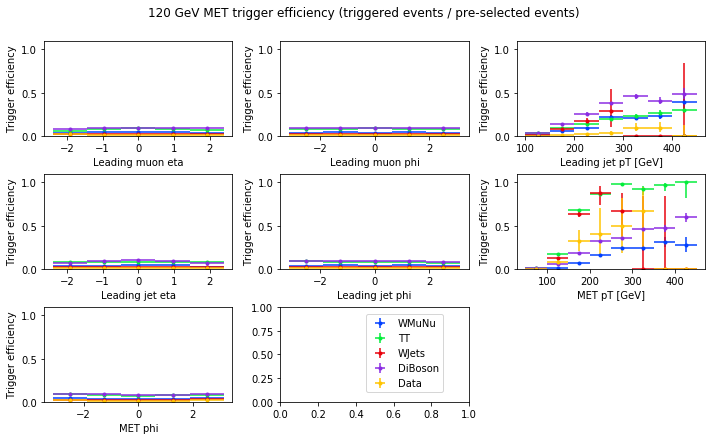

In [40]:
fig, axes = plt.subplots(3,3, figsize=(10,6))
fig.suptitle('120 GeV MET trigger efficiency (triggered events / pre-selected events)')
plt.tight_layout(h_pad=2.0)
fig.subplots_adjust(top=0.90)
#axes[2,1].axis('off')
axes[2,2].axis('off')

for index, (column, properties) in enumerate(eff_plots.items()):
    ax = axes[index//3, index%3]
    
    bin_edges = properties['axis']
    
    for sample, objs in samples.items():
        #if objs['label'] is not 'WJets':
        #    continue
        df = samples[sample]['enrich'].groupby('entry').nth(0)
        if 'h0' in locals():
            del h0,h1
    
        h0 = ROOT.TH1F(f'h0_1', '', len(bin_edges)-1, bin_edges)
        h1 = ROOT.TH1F(f'h1_1', '', len(bin_edges)-1, bin_edges)

        #or l,x in objs['df'].query('fired0==True')[column].groupby('entry').nth(0).iteritems():
        #   h0.Fill(x)
        #or l,x in objs['df'].query('fired0==True & fired==True')[column].groupby('entry').nth(0).iteritems():
        #   h1.Fill(x)
            
        for l,x in df[df['fired0']==True][column].iteritems():
            h0.Fill(x)
        for l,x in df[(df['fired0']==True) & (df['fired']==True)][column].iteritems():
            h1.Fill(x)

        eff = ROOT.TEfficiency(h1, h0)
        data = extract_teffi(eff)

        #print(data['x'])
        if 'Pt' in column:# 'pt':
            xerr=np.diff(bin_edges)/2
        else:
            xerr = np.insert(np.diff(data['x'])/2, 0, (data['x'][1]-data['x'][0])/2)
        if len(data['x']) != len(properties['axis'])-1:
            recover = np.add(np.diff(properties['axis'])/2,properties['axis'][:-1])
            data['x']= np.append(data['x'],recover[len(data['x']):])
            data['y']= np.append(data['y'],np.full(len(recover)-len(data['y']),0))
            data['yerr']= np.append(data['yerr'],np.full((2,len(recover)-len(data['yerr'][0])),0),axis=1)
        #print(xerr)
        #print(data['x'])
        ax.errorbar(x=data['x'], y=data['y'], xerr=xerr, yerr=data['yerr'],
                    fmt='o', label=f'{objs["label"]}', ms=3, c=objs['color'])
        ax.set_xlabel(properties['label'])
        ax.set_ylabel('Trigger efficiency')
        ax.set_ylim(0,1.1)
        
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc=(-0.8,0.1));

fig.savefig(f'{web_dir}/trigger_eff_preselected.png', bbox_inches='tight')

[0.00329378 0.00132745 0.00070262 0.00059099 0.00063025 0.00048766
 0.00046911 0.00052595 0.00040529 0.00035424 0.00039103 0.00039982
 0.00041183 0.00042084 0.00043993 0.00044908 0.00052548 0.00054879
 0.00065533 0.00078565 0.00086868 0.00107468 0.00124313 0.00142731
 0.00159837 0.00187635 0.00209676 0.00239435 0.00261523 0.00284611
 0.00315409 0.00332347 0.00364196 0.0039052  0.00406384 0.00429494
 0.00465046 0.00502489 0.00526119 0.00555145 0.00587405 0.00628684
 0.00651851 0.00708536 0.00714576 0.00745711 0.00798246 0.00841904
 0.00862576 0.00917501 0.00980964 0.01032164 0.0105613  0.01081113
 0.01191827 0.0124132  0.01289759 0.0132734  0.01314519 0.0140641
 0.01500866 0.01486633 0.01540086 0.01625688 0.01723247 0.01692633
 0.01852807 0.01922076 0.02042578 0.02073023 0.0214992  0.0213549
 0.02199237 0.02305526 0.02405743 0.02372992 0.02557341 0.02839652]
[ZZ]
fit parameter 1-sigma error
———————————–
165.80 +- 3.22
56.13 +- 3.32
0.17 +- 0.00
0.17 +- 0.00

[0.00246152 0.00129034 0.000

OSError: [Errno 127] Key has expired: '/publicweb/m/mreid/iDM_AN_Plots/MetTriggerStudy/trigger_vs_met_fit_preselected_cf_DiBoson.png'

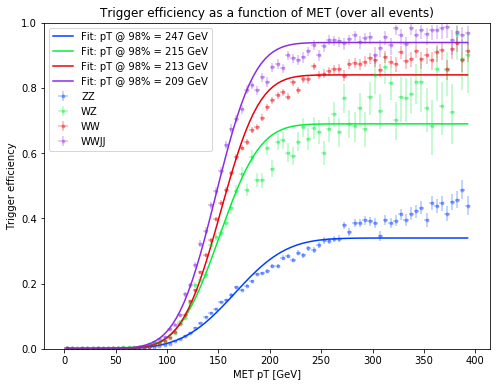

In [85]:
# Using cf (curve_fit), no x or y errors in the fit

fig, ax = plt.subplots(figsize=(8,6))
for index, (sample, props) in enumerate(samples.items()):
    #if props['label'] is not 'DiBoson':
    #    continue
    make_plot_fit_cf(ax, sample, props, 'recoPFMetPt', eff_plots['recoPFMetPt'], event_selection='enrich')

fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_cf_DiBoson.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_cf.png', bbox_inches='tight')

In [ ]:
# Using ODR, includes both x errors (bin width) and y errors

fig, ax = plt.subplots(figsize=(8,6))
for index, (sample, props) in enumerate(samples.items()):
    #if props['label'] is not 'DiBoson':
    #    continue
    make_plot_fit_odr(ax, sample, props, 'recoPFMetPt', eff_plots['recoPFMetPt'], event_selection='enrich')

fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_ODR_DiBoson.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_ODR.png', bbox_inches='tight')

# Trigger efficiency of `MET_120`  vs kinematic distributions -- all events